# Load the model

In [1]:
%matplotlib inline
from skimage import transform
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn.functional as F
import io
import PIL.Image
import cv2
from torch.utils.data import DataLoader
from floortrans.models import get_model
from floortrans.loaders import FloorplanSVG, DictToTensor, Compose, RotateNTurns
from floortrans.plotting import segmentation_plot, polygons_to_image, draw_junction_from_dict, discrete_cmap
discrete_cmap()
from floortrans.post_prosessing import split_prediction, get_polygons, split_validation
from mpl_toolkits.axes_grid1 import AxesGrid


rot = RotateNTurns()
room_classes = ["Background", "Outdoor", "Wall", "Kitchen", "Living Room" ,"Bed Room", "Bath", "Entry", "Railing", "Storage", "Garage", "Undefined"]
icon_classes = ["No Icon", "Window", "Door", "Closet", "Electrical Applience" ,"Toilet", "Sink", "Sauna Bench", "Fire Place", "Bathtub", "Chimney"]

data_folder = 'data/cubicasa5k/'
data_file = 'test.txt'
normal_set = FloorplanSVG(data_folder, data_file, format='txt', original_size=True)
data_loader = DataLoader(normal_set, batch_size=1, num_workers=0)
data_iter = iter(data_loader)
# Setup Model
model = get_model('hg_furukawa_original', 51)

n_classes = 44
split = [21, 12, 11]
model.conv4_ = torch.nn.Conv2d(256, n_classes, bias=True, kernel_size=1)
model.upsample = torch.nn.ConvTranspose2d(n_classes, n_classes, kernel_size=4, stride=4)
checkpoint = torch.load('model_best_val_loss_var.pkl')

model.load_state_dict(checkpoint['model_state'])
model.eval()
model.cuda()
print("Model loaded!")

Model loaded!


# Loading the scaled plan drawing

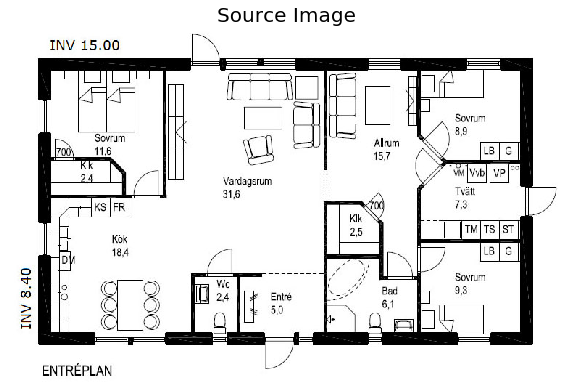

In [2]:
val = next(data_iter)
junctions = val['heatmaps']
folder = val['folder'][0]
image = val['image'].cuda()
label = val['label']
np_img = np.moveaxis(image[0].cpu().data.numpy(), 0, -1) / 2 + 0.5
plt.figure(figsize=(10,10))
plt.title('Source Image', fontsize=20)
plt.axis('off')
plt.imshow(np_img)
plt.show()

folder_true = folder[1:]

# Showing the model.svg file that is premade, not interested in this either

In [3]:
#from IPython.display import Image
#from IPython.core.display import HTML 
#folder = folder[1:]
#Image(url=data_folder+folder+"model.svg", width=800)
#print(folder)

# This is for the preprocessed model.svg files, I don't want to run this but the later parts are what I am interested in

In [4]:
'''plt.figure(figsize=(10,10))
ax = plt.subplot(1, 1, 1)
plt.title('Rooms and walls', fontsize=20)
ax.axis('off')
rseg = ax.imshow(label_np[0], cmap='rooms', vmin=0, vmax=n_rooms-0.1)
cbar = plt.colorbar(rseg, ticks=np.arange(n_rooms) + 0.5, fraction=0.046, pad=0.01)
cbar.ax.set_yticklabels(room_classes, fontsize=20)
plt.show()

plt.figure(figsize=(10,10))
ax = plt.subplot(1, 1, 1)
plt.title('Icons', fontsize=20)
ax.axis('off')
iseg = ax.imshow(label_np[1], cmap='icons', vmin=0, vmax=n_icons-0.1)
cbar = plt.colorbar(iseg, ticks=np.arange(n_icons) + 0.5, fraction=0.046, pad=0.01)
cbar.ax.set_yticklabels(icon_classes, fontsize=20)
plt.show()

plt.figure(figsize=(10,10))
ax = plt.subplot(1, 1, 1)
plt.title('Wall junctions, Icon corners and opening end points', fontsize=20)
ax.axis('off')
ax.imshow(np_img)
h, w, _ = np_img.shape
draw_junction_from_dict(junctions, w, h, size=0.3, fontsize=10)
plt.show()'''

"plt.figure(figsize=(10,10))\nax = plt.subplot(1, 1, 1)\nplt.title('Rooms and walls', fontsize=20)\nax.axis('off')\nrseg = ax.imshow(label_np[0], cmap='rooms', vmin=0, vmax=n_rooms-0.1)\ncbar = plt.colorbar(rseg, ticks=np.arange(n_rooms) + 0.5, fraction=0.046, pad=0.01)\ncbar.ax.set_yticklabels(room_classes, fontsize=20)\nplt.show()\n\nplt.figure(figsize=(10,10))\nax = plt.subplot(1, 1, 1)\nplt.title('Icons', fontsize=20)\nax.axis('off')\niseg = ax.imshow(label_np[1], cmap='icons', vmin=0, vmax=n_icons-0.1)\ncbar = plt.colorbar(iseg, ticks=np.arange(n_icons) + 0.5, fraction=0.046, pad=0.01)\ncbar.ax.set_yticklabels(icon_classes, fontsize=20)\nplt.show()\n\nplt.figure(figsize=(10,10))\nax = plt.subplot(1, 1, 1)\nplt.title('Wall junctions, Icon corners and opening end points', fontsize=20)\nax.axis('off')\nax.imshow(np_img)\nh, w, _ = np_img.shape\ndraw_junction_from_dict(junctions, w, h, size=0.3, fontsize=10)\nplt.show()"

# Segmentation, this is where the rooms are first divided into the color blocks.

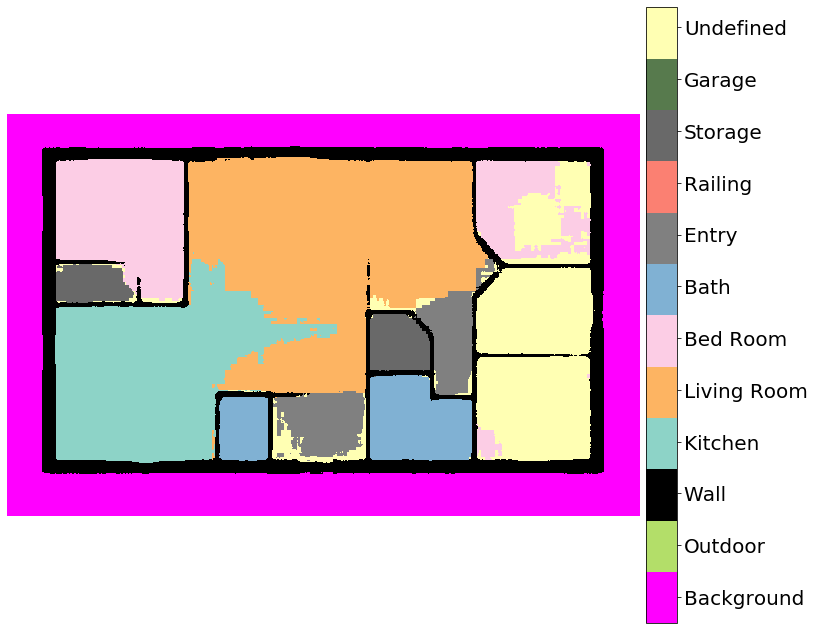

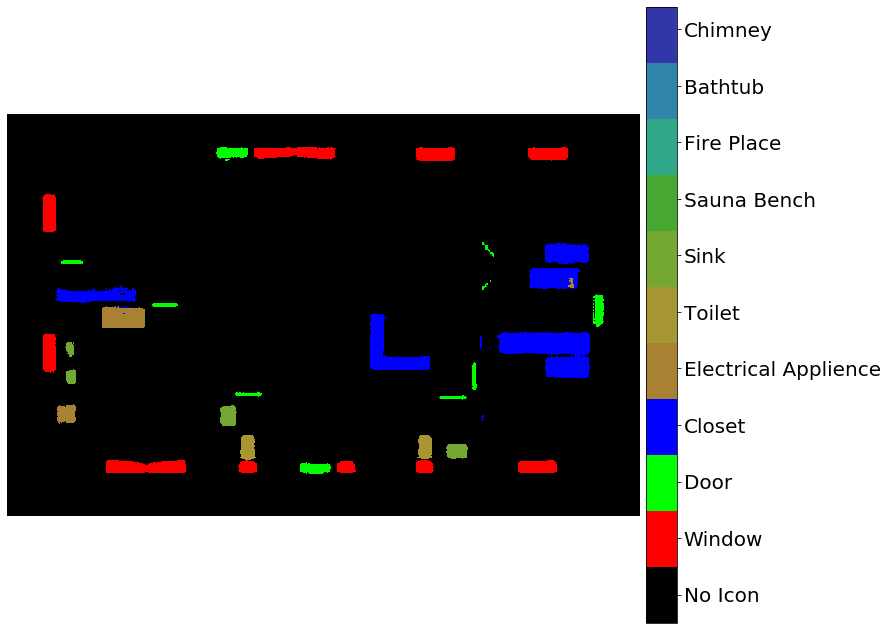

In [3]:
label_np = label.data.numpy()[0]
n_rooms = 12
n_icons = 11

with torch.no_grad():
    height = label_np.shape[1]
    width = label_np.shape[2]
    img_size = (height, width)
    
    rotations = [(0, 0), (1, -1), (2, 2), (-1, 1)]
    pred_count = len(rotations)
    prediction = torch.zeros([pred_count, n_classes, height, width])
    for i, r in enumerate(rotations):
        forward, back = r
        # We rotate first the image
        rot_image = rot(image, 'tensor', forward)
        pred = model(rot_image)
        # We rotate prediction back
        pred = rot(pred, 'tensor', back)
        # We fix heatmaps
        pred = rot(pred, 'points', back)
        # We make sure the size is correct
        pred = F.interpolate(pred, size=(height, width), mode='bilinear', align_corners=True)
        # We add the prediction to output
        prediction[i] = pred[0]

prediction = torch.mean(prediction, 0, True)
rooms_label = label_np[0]
icons_label = label_np[1]

rooms_pred = F.softmax(prediction[0, 21:21+12], 0).cpu().data.numpy()
rooms_pred = np.argmax(rooms_pred, axis=0)

icons_pred = F.softmax(prediction[0, 21+12:], 0).cpu().data.numpy()
icons_pred = np.argmax(icons_pred, axis=0)

plt.figure(figsize=(12,12))
ax = plt.subplot(1, 1, 1)
ax.axis('off')
rseg = ax.imshow(rooms_pred, cmap='rooms', vmin=0, vmax=n_rooms-0.1)
cbar = plt.colorbar(rseg, ticks=np.arange(n_rooms) + 0.5, fraction=0.046, pad=0.01)
cbar.ax.set_yticklabels(room_classes, fontsize=20)
plt.show()

plt.figure(figsize=(12,12))
ax = plt.subplot(1, 1, 1)
ax.axis('off')
iseg = ax.imshow(icons_pred, cmap='icons', vmin=0, vmax=n_icons-0.1)
cbar = plt.colorbar(iseg, ticks=np.arange(n_icons) + 0.5, fraction=0.046, pad=0.01)
cbar.ax.set_yticklabels(icon_classes, fontsize=20)
plt.show()

# Processing the rough segmentation into clean blocks

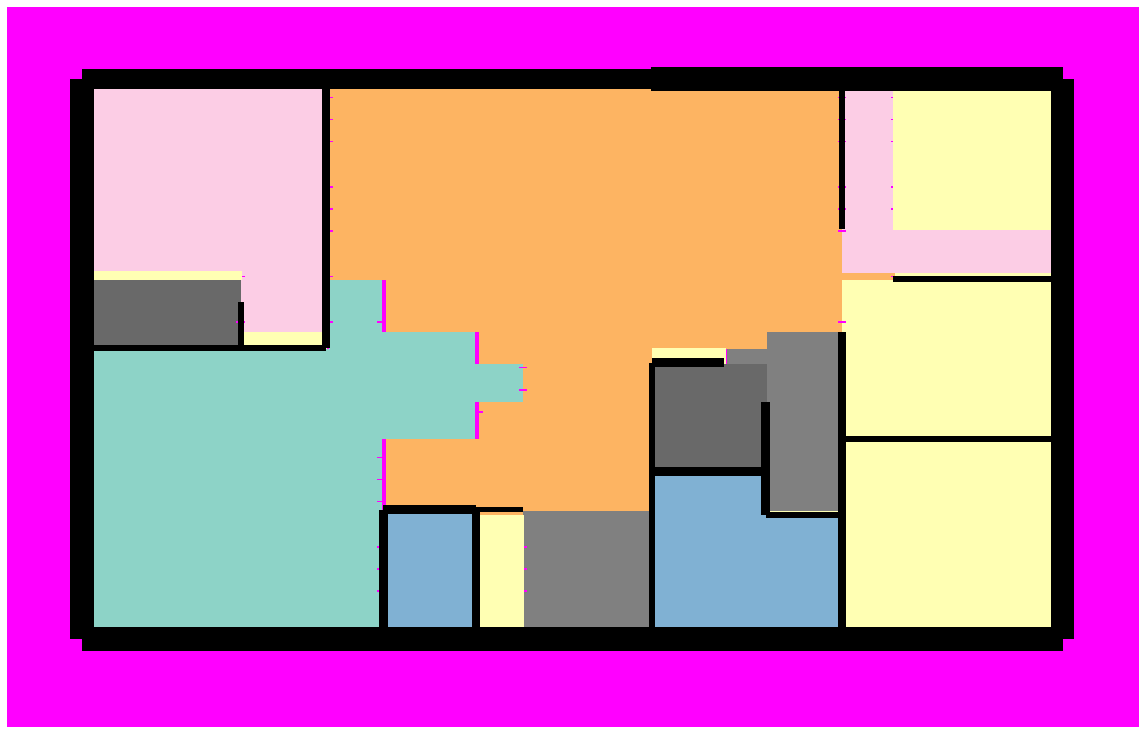

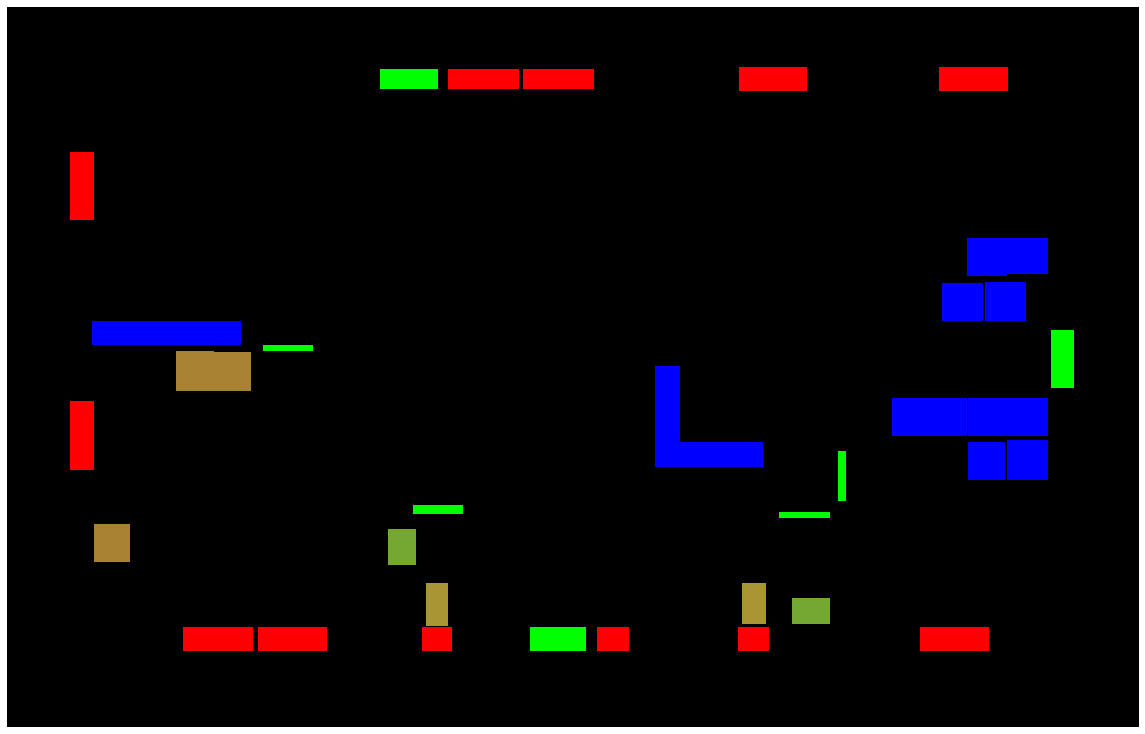

In [4]:
heatmaps, rooms, icons = split_prediction(prediction, img_size, split)
polygons, types, room_polygons, room_types = get_polygons((heatmaps, rooms, icons), 0.2, [1, 2])

buf = io.BytesIO()
buf2 = io.BytesIO()

x_size = width/height*10
y_size = 10

# Fix the areas to clean polygons
pol_room_seg, pol_icon_seg = polygons_to_image(polygons, types, room_polygons, room_types, height, width)

fig = plt.figure(frameon=False)
fig.set_size_inches(x_size, y_size, forward=False)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.axis('off')
fig.add_axes(ax)
rseg = ax.imshow(pol_room_seg, cmap='rooms', vmin=0, vmax=n_rooms-0.1)
#cbar = plt.colorbar(rseg, ticks=np.arange(n_rooms) + 0.5, fraction=0.046, pad=0.01)
#cbar.ax.set_yticklabels(room_classes, fontsize=20)
#plt.tight_layout()
#plt.show()

plt.savefig(buf, format='png')
buf.seek(0)
im = PIL.Image.open(buf)
im.save('test1.png','PNG')

#For Icons add support later, have to change the colors in the code
fig = plt.figure(frameon=False)
fig.set_size_inches(x_size, y_size, forward=False)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.axis('off')
fig.add_axes(ax)
iseg = ax.imshow(pol_icon_seg, cmap='icons', vmin=0, vmax=n_icons-0.1)
#cbar.ax.set_yticklabels(icon_classes, fontsize=20)
#plt.tight_layout()
#plt.show()

plt.savefig(buf2, format='png')
buf2.seek(0)
im_icon = PIL.Image.open(buf2)
im_icon.save('test2.png','PNG')


In [35]:
filename = 'test'
resize = 256, 256

# generating the thumbnail from given size
im.thumbnail(resize, PIL.Image.ANTIALIAS)

offset_x = max((resize[0] - im.size[0]) / 2, 0)
offset_y = max((resize[1] - im.size[1]) / 2, 0)

offset_tuple = (int(offset_x), int(offset_y)) #pack x and y into a tuple

# create the image object to be the final product
im_room = PIL.Image.new(mode='RGBA',size=resize,color=(220, 220, 220, 255))

# paste the thumbnail into the full sized image
im_room.paste(im, offset_tuple)

final_im = im_room

# Adding the icons to the room map
im_icon.thumbnail(resize, PIL.Image.ANTIALIAS)
np_im_icon = np.array(im_icon)

# Removing the grey background for the icons so that we can paste it ontop of the room image.
np_im_icon[np.where((np_im_icon==[0, 0, 0, 255]).all(axis=2))] = [255,255,255,0]

# Making the np array to an image
final_icon_im = PIL.Image.fromarray(np_im_icon, 'RGBA')

# Pasting icons onto rooms
final_im.paste(final_icon_im, offset_tuple, final_icon_im)

# Getting the base image to paste next to the segmentated one for pix2pix
base_image = PIL.Image.open(data_folder+folder_true+'F1_original.png')
base_image.thumbnail(resize, PIL.Image.ANTIALIAS)

offset_x = max((resize[0] - base_image.size[0]) / 2, 0)
offset_y = max((resize[1] - base_image.size[1]) / 2, 0)

offset_tuple = (int(offset_x), int(offset_y)) #pack x and y into a tuple

final_base = PIL.Image.new(mode='RGBA',size=resize,color=(255, 255, 255, 255))
# paste the thumbnail into the full sized image
final_base.paste(base_image, offset_tuple)

combined_im = PIL.Image.new('RGBA', (512, 256), color=(255, 255, 255, 255))

combined_im.paste(final_base,(0, 0))
combined_im.paste(final_im,(256, 0))

# save (the PNG format will retain the alpha band unlike JPEG)
combined_im.save('test.png','PNG')

print('saved '+ filename)

saved test
